Exercise 2.5
Method sample_average
Method constant_step_size
Exercise 2.11
Method sample_average
Method constant_step_size
Method gradient
Method ucb
Method optimistic_init


TypeError: LogScale.__init__() got an unexpected keyword argument 'basex'

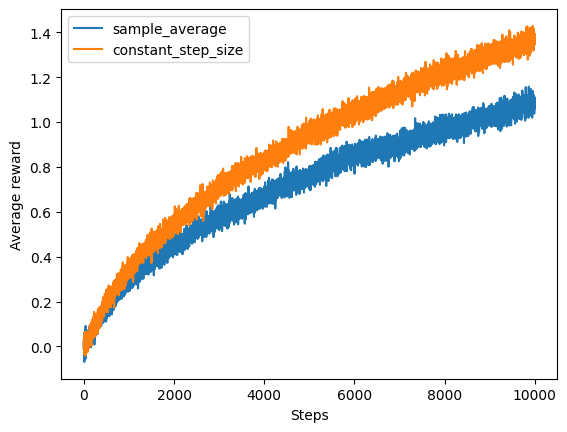

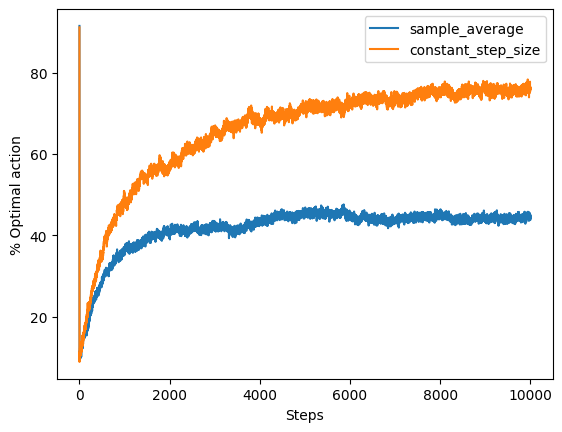

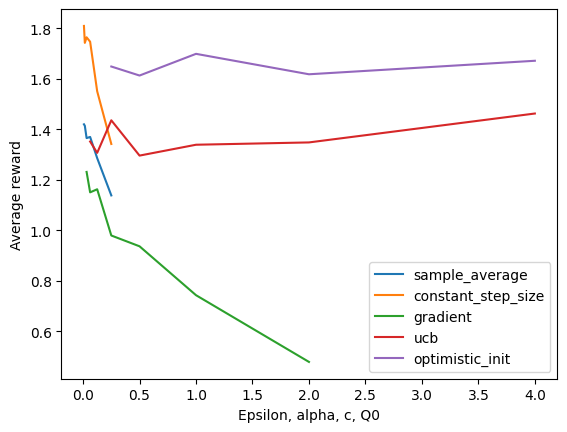

In [44]:
import numpy as np
import matplotlib.pyplot as plt


# A wrapper class for parameters of the algorithm
class Params:
    def __init__(self):
        # number of bandit's arms
        self.k = 10

        # mean and standard deviation random walk of q_star
        self.mu, self.sigma = 0, 0.01

        # number of k-armed bandit problems
        self.m = None

        # step size
        self.alpha = 0.1

        # step size possible values
        self.alphas = [2 ** x for x in range(-5, 2)]

        # epsilon-greedy parameter epsilon
        self.epsilon = 0.1

        # epsilon-greedy parameter epsilon possible values
        self.epsilons = [2 ** x for x in range(-7, -1)]

        # UCB parameter c possible values
        self.cs = [2 ** x for x in range(-4, 3)]

        # greedy with optimistic initialization possible initialization values
        self.initializations = [2 ** x for x in range(-2, 3)]

        # steps of a run
        self.steps = None

        # number of last steps over the average is computed
        self.last_steps_eval = 10000

        # names of the algorithms used to solve the k-armed bandit problem
        self.bandit_types = None


# A wrapper class for an algorithm to solve the k-armed bandit problem
class Bandit:
    def __init__(self, bandit_type, k, epsilon, m, alpha, c=None, initialization=None):
        """
        :param bandit_type: algorithm used to solve the k-armed bandit problem
        :param k: number of arms of a bandit
        :param epsilon:
        :param m: number of bandits
        :param alpha: step size
        :param c: UCB method coefficient (default None)
        :param initialization: initial estimation for each action (default None)
        """
        # Set up the parameters
        self.bandit_type = bandit_type
        self.k = k
        self.epsilon = epsilon
        self.m = m
        self.alpha = alpha
        self.c = c
        self.initialization = initialization

        # Table q_star, real reward mean for each action of each bandit
        self.q_star = np.zeros((self.m, self.k))

        # Table N, used for sample-average method
        self.N = np.zeros((self.m, self.k))

        # Time variable, used for UCB method
        self.time = 0

        # Table Q, estimate reward mean for each action of each bandit (zero if there is no initialization)
        if initialization is None:
            self.Q = np.zeros((self.m, self.k))
        else:
            self.Q = np.full((self.m, self.k), initialization)

    def step(self):
        """
        Choose action for each bandit, observe results and update appropriate tables
        :return: actions taken and reward obtained
        """
        # Sample average action selection algorithm
        if self.bandit_type == 'sample_average':
            # Choose the action to take for each bandit
            A = [np.argmax(row) if np.random.binomial(1, self.epsilon) == 0 else int(np.random.uniform(0, self.k)) for
                 row in self.Q[:, ]]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update N and Q tables
            self.N = np.reshape([self.N[i, :] + Bandit.one_hot(value, self.k) for i, value in enumerate(A)],
                                (self.m, self.k))
            self.Q = np.reshape([self.Q[i, :] + (1 / self.N[i, value]) * (R[i] - self.Q[i, value]) *
                                 Bandit.one_hot(value, self.k) for i, value in enumerate(A)], (self.m, self.k))

        # Sample average action selection algorithm with constant step size, with zero or optimistic initialization
        elif self.bandit_type == 'constant_step_size' or self.bandit_type == 'optimistic_init':
            # Choose the action to take for each bandit
            A = [np.argmax(row) if np.random.binomial(1, self.epsilon) == 0 else int(np.random.uniform(0, self.k)) for
                 row in self.Q[:, ]]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update Q table
            self.Q = np.reshape([self.Q[i, :] + self.alpha * (R[i] - self.Q[i, value]) * Bandit.one_hot(value, self.k)
                                 for i, value in enumerate(A)], (self.m, self.k))

        # Gradient bandit algorithm
        elif self.bandit_type == 'gradient':
            A_probability = [np.exp(row)/np.sum(np.exp(row)) for row in self.Q[:, ]]

            # Choose the action to take for each bandit
            A = [np.random.choice(np.arange(self.k), p=p) for p in A_probability]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update Q table
            self.Q = np.reshape([self.Q[i, :] + self.alpha * R[i] * (Bandit.one_hot(value, self.k) - A_probability[i])
                                 for i, value in enumerate(A)], (self.m, self.k))

        # Upper-Confidence-Bound action selection algorithm
        elif self.bandit_type == 'ucb':
            # Choose the action to take for each bandit
            A = [np.argmax(row + self.c * np.sqrt(np.log(self.time + 1) / (n + 1))) if
                 np.random.binomial(1,self.epsilon) == 0 else int(np.random.uniform(0, self.k)) for row, n in
                 zip(self.Q[:, ], self.N[:, ])]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update time value
            self.time += 1

            # Update N and Q tables
            self.N = np.reshape([self.N[i, :] + Bandit.one_hot(value, self.k) for i, value in enumerate(A)],
                                (self.m, self.k))
            self.Q = np.reshape([self.Q[i, :] + (1 / self.N[i, value]) * (R[i] - self.Q[i, value]) *
                                 Bandit.one_hot(value, self.k) for i, value in enumerate(A)], (self.m, self.k))

        return A, R


    @staticmethod
    def one_hot(position, length):
        """
        :param position: position of the '1' value
        :param length: length of the array
        :return: one-hot encoded vector, with all '0' except for one '1'
        """
        assert length > position, 'position {:d} greater than or equal to length {:d}'.format(position, length)
        oh = np.zeros(length)
        oh[position] = 1
        return oh


def show_results2_5(bandit_types, ARs, POAs):
    """
    Show the result, for exercise 2.5
    :param bandit_types: names of the algorithms used to solve the k-armed bandit problem
    :param ARs: average reward value, for each algorithm and for each step
    :param POAs: percentage of optimal action chosen value, for each algorithm and for each step
    """
    for bandit_type, AR, POA in zip(bandit_types, ARs, POAs):
        plt.figure(0)
        plt.plot(AR, label=bandit_type)
        plt.legend(loc='best')
        plt.xlabel('Steps')
        plt.ylabel('Average reward')

        plt.figure(1)
        plt.plot(POA, label=bandit_type)
        plt.legend(loc='best')
        plt.xlabel('Steps')
        plt.ylabel('% Optimal action')


def show_results2_11(bandit_types, ARs, params):
    """
    Show the result, for exercise 2.5
    :param bandit_types: names of the algorithms used to solve the k-armed bandit problem
    :param ARs: average reward value, for each algorithm and for each fundamental parameter configuration
    :param params: parameters
    :return:
    """
    for bandit_type, ARs_ in zip(bandit_types, ARs):
        plt.figure(2)
        if bandit_type == 'sample_average' or bandit_type == 'constant_step_size':
            plt.plot(params.epsilons, ARs_, label=bandit_type)

        if bandit_type == 'gradient':
            plt.plot(params.alphas, ARs_, label=bandit_type)

        if bandit_type == 'ucb':
            plt.plot(params.cs, ARs_, label=bandit_type)

        if bandit_type == 'optimistic_init':
            plt.plot(params.initializations, ARs_, label=bandit_type)

    plt.legend(loc='best')
    plt.xlabel('Epsilon, alpha, c, Q0')
    plt.ylabel('Average reward')
    plt.set_xscale('log', basex=2)


def exercise2_5():
    print('Exercise 2.5')

    # Set up parameters
    params = Params()

    params.m = 2000
    params.steps = 10000
    params.bandit_types = ['sample_average', 'constant_step_size']

    ARs = []
    POAs = []

    for bandit_type in params.bandit_types:
        print('Method', bandit_type)

        # Average Reward
        AR = []

        # Percentage of Optimal Action
        POA = []

        # Set up the algorithm
        bandit = Bandit(bandit_type, params.k, params.epsilon, params.m, params.alpha)

        for _ in range(params.steps):
            # Take a step
            A, R = bandit.step()

            # Collect rewards and compute the percentage of optimal values
            AR.append(np.average(R))
            POA.append(np.average([100 if value == np.argmax(bandit.q_star[i, :]) else 0 for i, value in enumerate(A)]))

            # Change a little the true value of every arm of every bandit
            bandit.q_star += np.random.normal(params.mu, params.sigma, (params.m, params.k))

        ARs.append(AR)
        POAs.append(POA)

    # Show results
    show_results2_5(params.bandit_types, ARs, POAs)


def exercise2_11():
    print('Exercise 2.11')

    # Set up parameters
    params = Params()

    params.m = 200
    params.steps = 20000
    params.bandit_types = ['sample_average', 'constant_step_size', 'gradient', 'ucb', 'optimistic_init']

    # Average Rewards for different bandits
    ARs = []

    for bandit_type in params.bandit_types:
        print('Method', bandit_type)

        # Average Rewards for bandits with a different variable
        ARs_ = []

        bandits = []

        # Generate a bandit for each possible epsilon value
        if bandit_type == 'sample_average' or bandit_type == 'constant_step_size':
            for epsilon in params.epsilons:
                bandits.append(Bandit(bandit_type, params.k, epsilon, params.m, params.alpha))

        # Generate a bandit for each possible alpha value
        elif bandit_type == 'gradient':
            for alpha in params.alphas:
                bandits.append(Bandit(bandit_type, params.k, params.epsilon, params.m, alpha))

        # Generate a bandit for each possible c value
        elif bandit_type == 'ucb':
            for c in params.cs:
                bandits.append(Bandit(bandit_type, params.k, params.epsilon, params.m, params.alpha, c=c))

        # Generate a bandit for each possible initial value
        elif bandit_type == 'optimistic_init':
            for initialization in params.initializations:
                bandits.append(Bandit(bandit_type, params.k, params.epsilon, params.m, params.alpha,
                                      initialization=initialization))

        for bandit in bandits:

            # Average Reward
            AR = []

            for i in range(params.steps):
                # Take a step
                A, R = bandit.step()

                # Collect rewards
                AR.append(np.average(R))

                # Change a little the true value of every arm of every bandit
                bandit.q_star += np.random.normal(params.mu, params.sigma, (params.m, params.k))

            ARs_.append(np.average(AR[-params.last_steps_eval:]))
        ARs.append(ARs_)

    # Show results
    show_results2_11(params.bandit_types, ARs, params)

exercise2_5()
exercise2_11()
plt.show()